<center>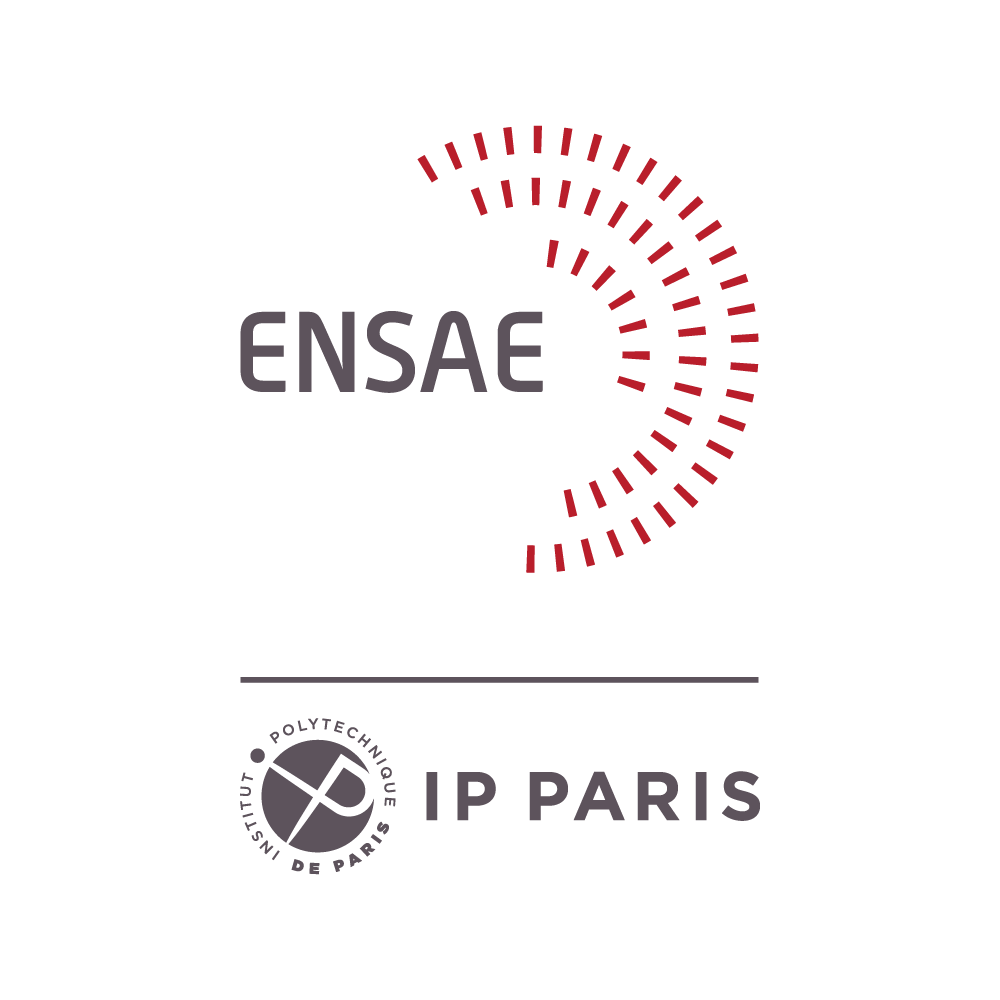</center>

<h1><center><strong><font color="black"> NLP course : Political party prediction based on tweets </font></strong></center></h1>
<h3><center><font color="black"><strong>Justin Aguenier & Violaine Courrier</strong></font></center></h3>

<center>
2022 
</center>

# I- Project description

*Project Framing* :

The **key questions** we aim to answer are the following ones : 

- Are we able to impute a political bias to textual data ?
- Can we understand the textual differences between the different political sensibilities ? 

After researhcing for textual data labeled for different political parties, we prefer to focus on US data and especially tweets as the data is available. The different datasets we have been using for our work are the followings ones :

  - dataset 1 
  - dataset 2 


For our first experiment, we tried to classify tweets. This classification have several applications : 

  - Detect political bias of twitter bots 
  - ....

Our protocole is the following one : 


  - Technique : 
  - Task : sequence classification 
  - Model : 
  - Preprocessing :
  - Training : 
  - Evaluation : 

## 2. Textual Data

## 3. Descriptive Statistics

## 4. Embedding techniques

## 5. Task specific modelling

## Load the dataset from kaggle (tutorial included :) )  

To load the dataset, you need to authenticate with the Kaggle services. For this purpose, you need an API token. This token can be easily generated from the profile section of your Kaggle account. Simply, navigate to your Kaggle profile, then click the ```Account```  tab and then scroll down to the ```API``` section where you can click on "Create new API token". \\
A file named ```kaggle.json``` will be download which contains the username and the API key. You now just have to import it on this colab environment.

**Execute the following cell** and **answer** ```y``` to the question ```replace senators.csv?```

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download rishidamarla/tweets-of-us-senators
! unzip tweets-of-us-senators.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
 73% 15.0M/20.6M [00:00<00:00, 71.3MB/s]
100% 20.6M/20.6M [00:00<00:00, 70.3MB/s]
Archive:  tweets-of-us-senators.zip
  inflating: senators.csv            


## II - Dependencies 

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from termcolor import colored

# II - Data cleaning

## Data reading 

In [ ]:
df = pd.read_csv("senators.csv", encoding = "ISO-8859-1", parse_dates=['created_at'])
df.head()

created_at                                               text  \
0 2017-10-19 21:47:00  We released bipartisan healthcare bill today &...   
1 2017-10-19 18:48:00  I spoke with @Morning_Joe team abt #HonestAds ...   
2 2017-10-19 18:14:00  Lots of interest in my bill with Senators Warn...   
3 2017-10-19 18:04:00  Today's the day @MarkWarner, @SenJohnMcCain &a...   
4 2017-10-19 16:33:00  .@MarkWarner, @SenJohnMcCain &amp; I put toget...   

                                                 url  replies  retweets  \
0  https://twitter.com/amyklobuchar/status/921130...       21       129   
1  https://twitter.com/amyklobuchar/status/921085...        8        46   
2  https://twitter.com/amyklobuchar/status/921077...       36       227   
3  https://twitter.com/amyklobuchar/status/921074...       17       167   
4  https://twitter.com/amyklobuchar/status/921051...       31       279   

   favorites          user bioguide_id party state  
0        533  amyklobuchar     K000367     D    MN  
1        150  amyklobuchar     K000367     D    MN  
2        932  amyklobuchar     K000367     D    MN  
3        550  amyklobuchar     K000367     D    MN  
4        893  amyklobuchar     K000367     D    MN

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288615 entries, 0 to 288614
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   created_at   288615 non-null  datetime64[ns]
 1   text         288615 non-null  object        
 2   url          288615 non-null  object        
 3   replies      288615 non-null  int64         
 4   retweets     288615 non-null  int64         
 5   favorites    288615 non-null  int64         
 6   user         288615 non-null  object        
 7   bioguide_id  288615 non-null  object        
 8   party        288615 non-null  object        
 9   state        288615 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 22.0+ MB


Our dataset has 10 variables. The most important ones are **text** and **party** as the first one will be our **input** and the second will be our **target**. We drop the unnecessary variables : 

In [ ]:
df = df.drop(['bioguide_id'],axis=1)

## NaNs and duplicates research 

Some of the tweets are truncated, and they have a "äó_" in them, so we decided to remove them from our datasets.

In [ ]:
print(f"Before deletion the dataset has {len(df)} rows")

Before deletion the dataset has 288615 rows


In [ ]:
df = df.drop(df[df['text'].str.contains('äó_')].index)

In [ ]:
len(df.drop_duplicates()), len(df), len(df.text.unique())

(228533, 228533, 227646)

We have **no duplicates** in our dataset. Nevertheless as the number of unique tweets is different than the number of rows in our dataset, we have some repeated tweets. How is this possible ? Retweet ? Luck ? We look for the reason behind those repetitions : 

In [ ]:
df_duplicate = df.loc[df["text"].duplicated()]

In [ ]:
random_index = np.random.choice(df_duplicate.index)
random_text = df_duplicate.loc[random_index, "text"]
random_index, random_text

(271171, 'Joining @newsradio1029 soon. Tune in!')

In [ ]:
df.loc[[random_text in i for i in df.text], "url"]

271062    https://twitter.com/SenTomCotton/status/841628...
271171    https://twitter.com/SenTomCotton/status/836566...
271252    https://twitter.com/SenTomCotton/status/831495...
Name: url, dtype: object

The repeated tweets are either different users retweeting the same tweet, or an error, so we simply decided to **remove the recurrences** as their number is small.

In [ ]:
df = df.drop_duplicates(subset=['text'], ignore_index=True)

# III - Data exploration

## Global description

In [ ]:
print(f"We have {len(df.text.unique())} unique tweets available in our dataset !")

We have 227646 unique tweets available in our dataset !


In [ ]:
print(f"We have {len(df.party.unique())} unique tweets available in the dataset : {df.party.unique()}")

We have 3 unique tweets available in the dataset : ['D' 'R' 'I']


**D** stands for Democrat, **R** stands for Republican and eventually **I** stands for Independant: 

Who are the Independants ? **SenSanders** and **SenAugus**

In [ ]:
df.loc[df.party == "I", "user"].unique()

array(['SenAngusKing', 'SenSanders'], dtype=object)



After some research **SenSanders** is thez account of Bernie Sanders who is considers as a left wing politician. The same obervation is made for **Augus King**. We may changer the independant tag to democrat. As we can see the usernamer seem to begin with **Sen***. Is the observation general ? 

In [ ]:
len(df.loc[["Sen" in i for i in df.user]])/len(df)

0.7006975743039632

Around 70% of the tweets have the same user pattern

## Data exploration questions to answer

This is more or less a useless information. Data Visaulisation is supposed to answer the following questions : 

- Is our data balanced ? 
  - Is the data balance between political parties ? 
  - Inside a party, is the data balanced between the different senators ? 


- Can we already observe some differences between the different parties ? 
  - Frequence of words ?
  - Hashtags ? 
  - Len of tweets ...

- Is the data clean ? 

  - Is the tweet format respected ? 

## Is the data balanced ? 

In [ ]:
import plotly.express as px

In [ ]:
px.histogram(df, x="party", histnorm='percent', title = "Party distribution", text_auto=True)

The data is balanced between the two main parties. We may set the **Independants** as **Democrats**. If this was the case, we would have an almost a perfect balanced dataset. The second question is : are the parties represented by a diversity of senators on twitter ? 

Thanks to **plotly sunburst** graph we can visualize the distribution of tweets per party and per candidate. You can **click** on the graph for more interations.

In [ ]:
px.sunburst(df, path=['party', 'user'], title= "Number of tweets per party / senator", width=1400, height=600)

We can gather plot the same type of graph but this time with retweets. This helps us to understant the popularity of each senator : 

In [ ]:
px.sunburst(df, path=['party', 'user'], values="retweets", title= "Number of retweets per party / senator", width=1400, height=600)

From the first graph we can say that the senators has globally the same tweet frequency. To me more precise, we could say that **senBillNelson** does not tweet much whereas **SenSenders** tweets more. The second graph informs us that that there is a popularity disparity between the senators. For instance, Bernis Sanders has a total of 15144944 retweets.

Conclusion : répondre à la question 

## What about the tweet lenght ?  

In [ ]:
df["text_lenght"] = df["text"].apply(len)

We can study the lenght distribution. It seems to be the same for the different parties. Nevertheless, we observe that some tweets have more than 280 characters. We clearly observe the old limitation of 140 characters. 

In [ ]:
fig = px.histogram(df, x="text_lenght", facet_col="party", histnorm="percent")
fig.add_vline( x = 140)

In [ ]:
df.loc[df.text_lenght > 280]

created_at                                               text  \
79056  2012-06-01 14:26:00  RT @USEmbassyBKK: #VisitUSA ö_óöçöö_ö_ö_...   
199401 2017-09-28 19:04:00  ä__ä__ä__ä__ä__ä__ä__ä__ä__ä__ä__ä__ä__ä__ä__ä...   

                                                      url  replies  retweets  \
79056   https://twitter.com/SenatorCollins/status/2085...        0         5   
199401  https://twitter.com/SenSherrodBrown/status/913...       11        50   

        favorites             user party state  text_lenght  
79056           1   SenatorCollins     R    ME          336  
199401        379  SenSherrodBrown     D    OH          310

We delete these few tweets from the database.


In [ ]:
df = df.loc[df.text_lenght < 280]

## How tweet are distributed across time ? 

In [ ]:
df['simple_date'] = df['created_at'].dt.date

We are able to observe the distribution of dates : 

In [ ]:
px.histogram(df, x="simple_date", nbins=20)

In [ ]:
print("First tweet was done at", df['simple_date'].min())
print("The latest tweet is ", df['simple_date'].max())

First tweet was done at 2008-09-04
The latest tweet is  2017-10-20


## Feature creation 

We may be interested about the global tweet activity. Therefore, we create the ```global_activity```variable 

In [ ]:
df['gloabal_activity'] = df['replies']+ df['favorites']+ df['retweets']

## Predict political party thanks to tweet activity ? 

In [ ]:
df.loc[df.party == "D","size"] = 1
df.loc[df.party == "R","size"] = 1
df.loc[df.party == "I","size"] = 0.5

It is interesting to check is the acticity implied by the tweets is the same based on the political party : 

In [ ]:
px.scatter_ternary(df.sample(10000), a="replies", b="favorites", c="retweets", color="party", opacity=0.5)


# IV - Preprocessing 

## Dependencies 

In [ ]:
# Usage of Phrases and Phraser from gensim
import nltk
from gensim.models.phrases import Phrases, Phraser
from nltk.tokenize import TweetTokenizer
nltk.download('punkt')
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Deleting encoding errors 

In [ ]:
data = df[["text", "party"]]
data

text party
0       We released bipartisan healthcare bill today &...     D
1       I spoke with @Morning_Joe team abt #HonestAds ...     D
2       Lots of interest in my bill with Senators Warn...     D
3       .@MarkWarner, @SenJohnMcCain &amp; I put toget...     D
4       Happy to announce @SenJohnMcCain has joined ou...     D
...                                                   ...   ...
227641  Such a zone would allow the flow of unfettered...     D
227642  I welcome greater cooperation between the U.S....     D
227643  Educacií_n sobre la prevencií_n del abuso sexu...     D
227644  Education on sexual assault prevention should ...     D
227645  25 years since passage, the ADA has helped ens...     D

[227644 rows x 2 columns]

We have noticed what appears to be encoding errors. (Mettre un exemple). To overcome this issue, we create the function ```replace_encoding_errors```, which use the ```deEmojify``` function to handle the emojis.

In [ ]:
def deEmojify(inputString):
    returnString = ""
    for character in inputString:
        try:
            character.encode("ascii")
            returnString += character
        except UnicodeEncodeError:
            returnString += ''
    return returnString

In [ ]:
def replace_encoding_errors(text):
  text = str(text.replace('äó»', "'").replace('äóÖ', "'").replace('äóî', '-').replace('äóñ', '-').replace('&amp;', '&').replace("�",""))
  text = deEmojify(text)
  return text

Then we create three functions that will help us to clean the different tokens thatwe get thanks to the ```TweetTokenizer()``` functions from ```nltk```. 

## Removing stop words ? 

Removing stop words may be dangerous for some task (eg., sentiment analysis). Here we can try to remove stop words for our classification task. We will train our model with options to check if the performances are the same !  (On doit enlever les stops words à la fin du traitement)

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
#from nltk.corpus import stopwords
#stops = set(stopwords.words('english'))

In [ ]:
import spacy
#loading the english language small model of spacy
en = spacy.load('en_core_web_sm')
stops = en.Defaults.stop_words
print(stops)

{'except', 'moreover', '‘re', 'many', 'regarding', 'formerly', 'forty', 'one', "'m", 'with', 'if', 'be', 'even', 'along', 'out', 'give', 'whatever', 'why', 'her', 'do', '‘m', 'when', 'three', 'ca', 'whom', 'against', 'other', 'everyone', 'either', 'himself', 'hence', 'about', 'through', 'two', 're', 'towards', 'often', 'me', 'hereafter', 'who', 'indeed', '‘ve', 'our', 'wherein', 'both', 'under', 'another', "'re", 'anywhere', 'throughout', 'nevertheless', 'seeming', 'namely', 'seem', 'serious', 'on', 'yet', 'noone', 'did', 'myself', 'cannot', 'fifty', 'down', 'four', 'between', 'else', 'his', 'back', 'elsewhere', 'into', 'here', 'am', 'toward', 'since', 'hereupon', 'nor', 'him', 'been', 'same', 'while', 'might', 'would', 'off', 'take', 'you', 'what', '’re', 'used', 'any', 'eight', 'third', 'though', '’ve', 'latterly', 'of', 'had', 'otherwise', 'first', 'someone', 'such', 'doing', 'nine', 'however', 'us', 'until', "n't", 'still', 'least', 'n’t', 'again', '’d', 'nothing', 'whole', 'always

In [ ]:
def remove_stopwords(tokens):
  tokens = filter(lambda x: x not in stops, tokens)
  return list(tokens)

## Removing hashtag, url, and html

In [ ]:
def remove_hashtags(tokens):
  tokens = map(lambda x: x.replace('#', ''), tokens)
  return list(tokens)

def remove_url(tokens):
  tokens = filter(lambda x: "http" not in x, tokens)
  return list(tokens)

def remove_html(tokens):
  tokens = filter(lambda x: x[0]+x[-1] != '<>', tokens)
  return list(tokens)


In [ ]:
from tqdm import tqdm
def tokenize_url_hashtags_by_tweet(corpus):
  """
  :param corpus: Pandas array that contains tweets
  :return tokenized_sentences: list of sentences represented with word tokens
  """ 
  tokenizer = TweetTokenizer()
  tokenized_sentences = []
  tokenized_senteces_stopwords = []

  # As corpus is a Pandas array of tweets, we are looping over each tweet
  for sample in tqdm(corpus):
    # Before tokenizing the tweets, we replace the encoding errors 
    sentence = replace_encoding_errors(sample)
    tokens = tokenizer.tokenize(sentence)
    tokens = remove_url(tokens)
    tokens = remove_html(tokens)
    tokens = remove_hashtags(tokens)
    tokens = list(map(lambda x: x.lower(), tokens))
    tokens_stop = remove_stopwords(tokens)
    tokenized_sentences.append(tokens)
    tokenized_senteces_stopwords.append(tokens_stop)
  return tokenized_sentences, tokenized_senteces_stopwords

In [ ]:
%%time
cleaned_tweets_data, cleaned_tweets_data_stop = tokenize_url_hashtags_by_tweet(data.text.array)

100%|██████████| 227644/227644 [00:27<00:00, 8191.97it/s]

CPU times: user 27 s, sys: 707 ms, total: 27.7 s
Wall time: 27.8 s


## Is the data clean enough ?

In [ ]:
def print_tweet(sentence):
  for token in sentence:
    print(token, end= ' ')

In [ ]:
i = np.random.choice(range(len(cleaned_tweets_data)))
print_tweet(cleaned_tweets_data[i])

picked up some heads at the taxidermist today . follow along today on @snapchat at " thehilldotcom " 

In [ ]:
print_tweet(cleaned_tweets_data_stop[i])

picked heads taxidermist today . follow today @snapchat " thehilldotcom " 

## Check for phrases 

In [ ]:
def clean_corpus(corpus, threshold=50, tweets=False):
 tokenized_sentences, tokenized_senteces_stopwords = tokenize_url_hashtags_by_tweet(corpus)
 phrases = Phrases(tokenized_sentences, threshold=threshold)

 # This lets you use it with less RAM and faster processing.
 # But it will no longer be possible to update the detector with new training 
 # samples
 phraser = Phraser(phrases)

 # Merging multi-word expressions in the tokenization
 clean_corpus = []
 for sentence in tokenized_sentences:
   clean_corpus.append(phraser[sentence])
 
 return clean_corpus

cleaned_pol = clean_corpus(data.text.array, threshold = 100)

100%|██████████| 227644/227644 [00:31<00:00, 7121.06it/s]


In [ ]:
cleaned_pol[np.random.choice(range(len(cleaned_pol)))]

['commending',
 'dedicated',
 'employees',
 'of',
 'nhdes',
 'for',
 'helping',
 'to',
 'protect',
 "nh's",
 'natural_resources',
 'at',
 'des',
 'awards',
 'in',
 'concord']

# V - Data visualization after preprocessing 

## Wordcloud 

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
df["new_text"] = cleaned_pol

In [ ]:
text_democrat = df.loc[df["party"] == "D", "new_text"].array.to_numpy().flatten()
text_republican = df.loc[df["party"] == "R", "new_text"].array.to_numpy().flatten()

In [ ]:
for index, tweet in enumerate(text_democrat):
  text_democrat[index] = ' '.join(tweet)
  
for index, tweet in enumerate(text_republican):
  text_republican[index] = ' '.join(tweet)

In [ ]:
text_democrat = ' '.join(text_democrat)
text_republican = ' '.join(text_republican)

In [ ]:
text_democrat = text_democrat.replace('today', '').replace('thank','').replace('rt', '')
text_republican = text_republican.replace('today', '').replace('thank','').replace('rt', '')

In [ ]:
plt.rcParams["figure.figsize"] = (10,10)

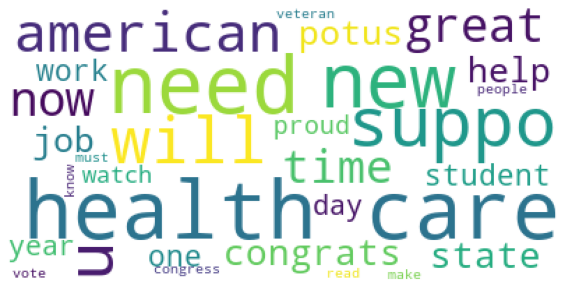

In [ ]:
wordcloud = WordCloud(background_color="white", max_words = 30).generate(text_democrat)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

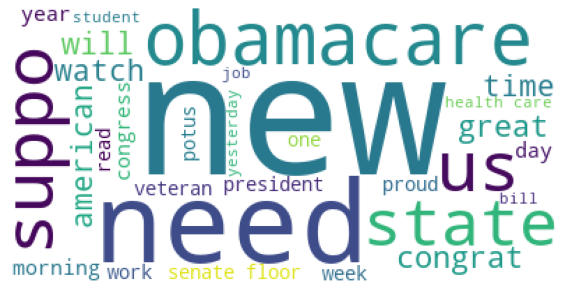

In [ ]:
wordcloud = WordCloud(background_color="white", max_words = 30).generate(text_republican)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Word2Vec differences 

The goal of this part is to know if we can notice differnce in the vector space between the political party. This would imply difference in thinking between the political parties.

In [ ]:
tweet_d = df.loc[df["party"]=="D", "new_text"].array
tweet_r = df.loc[df["party"]=="R", "new_text"].array

In [ ]:
from gensim.models import Word2Vec
from multiprocessing import cpu_count

cpu = cpu_count()
democrat = Word2Vec(tweet_d, size=100, window=3, min_count=3, workers=cpu)
democrat.train(tweet_d, total_examples=len(tweet_d), epochs=5)
democrat_wv = democrat.wv 


republican = Word2Vec(tweet_r, size=100, window=3, min_count=3, workers=cpu)
republican.train(tweet_r, total_examples=len(tweet_r), epochs=5)
republican_wv = republican.wv 


In [ ]:
democrat_wv.most_similar("environment", topn=10)

[('planet', 0.7797912359237671),
 ('oceans', 0.7500239610671997),
 ('publiclands', 0.7351030111312866),
 ('economy', 0.7172459363937378),
 ('prosperity', 0.6632521152496338),
 ('coastal_communities', 0.6516027450561523),
 ('society', 0.6506997346878052),
 ('public_lands', 0.6480094194412231),
 ('preserving', 0.6479324102401733),
 ('cleanwater', 0.646702229976654)]

In [ ]:
republican_wv.most_similar("environment", topn=10)

[('economic_growth', 0.7314203381538391),
 ('economy', 0.7269324064254761),
 ('job_creation', 0.6859425902366638),
 ('industry', 0.6850218772888184),
 ('workforce', 0.6827999353408813),
 ('infrastructure', 0.6803117394447327),
 ('tax_code', 0.6773611307144165),
 ('private_sector', 0.6476840972900391),
 ('reliable', 0.6461253762245178),
 ('natural_resources', 0.6450940370559692)]

We see a clear difference from the word ```environment```.

# III - Classification task

## a) Bag of words 

## b) Naive Bayes

## c) Logistic regression

## d) SVM

## e) BERT

## f) Neural Language model

Il faut : 
- créer ```train```,```test```, ```validation```
- convertir les label en 0,1 ? 
- Convertir en Dataset Pytorch et DataLoader 
- 

## Load fastText for embedding 

In [ ]:
# fasttext vectors can be imported through torch text (it will download it only once)
from torchtext.vocab import GloVe, vocab, FastText

# pretrained_vectors = GloVe(name="6B", dim='50')
pretrained_vectors = FastText(language='en')

## Our dataset to pyTorch format

In [ ]:
!pip install fast_ml

In [ ]:
df_classification = df[["text", "party"]]
df_classification.drop(df_classification[df_classification.party == 'I'].index, inplace=True)
df_classification = df_classification.reset_index()

In [ ]:
from fast_ml.model_development import train_valid_test_split

X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(df_classification, target = 'party', 
                                                                            train_size=0.8, valid_size=0.1, test_size=0.1)

print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)
print("y val shape: {}".format(y_test.shape))

(178041, 2)
(178041,)
(22255, 2)
(22255,)
(22256, 2)
(22256,)
y val shape: (22256,)


In [ ]:
train = X_train.join(y_train)
test = X_test.join(y_test)
validation = X_valid.join(y_valid)

In [ ]:
pretrained_vocab = vocab(pretrained_vectors.stoi)
unk_token = "<unk>"
unk_index = 0
pad_token = '<pad>'
pad_index = 1
pretrained_vocab.insert_token("<unk>",unk_index)
pretrained_vocab.insert_token("<pad>", pad_index)
#this is necessary otherwise it will throw runtime error if OOV token is queried 
pretrained_vocab.set_default_index(unk_index)
pretrained_embeddings = pretrained_vectors.vectors
pretrained_embeddings = torch.cat((torch.zeros(1,pretrained_embeddings.shape[1]),pretrained_embeddings))
pretrained_embeddings.size()

torch.Size([2519371, 300])

In [ ]:
def tokenize_pad_numericalize(corpus, vocab_stoi, max_length=100):
  tokenized_sentences, _ = tokenize_url_hashtags_by_tweet(corpus)
  list_padded_text = []
  for sentence_list in tokenized_sentences : 
    text = [vocab_stoi[token] if token in vocab_stoi else vocab_stoi['<unk>'] for token in sentence_list]
    padded_text = None
    if len(text) < max_length:   padded_text = text + [ vocab_stoi['<pad>'] for i in range(len(text), max_length) ] 
    elif len(text) > max_length: padded_text = text[:max_length]
    else:                        padded_text = text
    list_padded_text.append(padded_text)
  return list_padded_text

def tokenize_all(entries, vocab_stoi):
  #res = {}
  #res['text'] = [tokenize_pad_numericalize(entry, vocab_stoi, max_length=200) for entry in entries['text']]
  text_column = tokenize_pad_numericalize(entries['text'], vocab_stoi, max_length=200)
  #res['party'] = entries['party']
  party_column = pd.factorize(entries['party'])[0].tolist()
  res = pd.DataFrame({'text': text_column, 'party': party_column})
  return res

In [ ]:
numericalized_train = tokenize_all(train, pretrained_vocab.get_stoi())
numericalized_test = tokenize_all(test, pretrained_vocab.get_stoi())
numericalized_valid = tokenize_all(validation, pretrained_vocab.get_stoi())

100%|██████████| 22255/22255 [00:02<00:00, 8482.02it/s]


In [ ]:
from torch.utils.data import Dataset
import numpy as np

class TweetDataset(Dataset):
    def __init__(self, data, args):
      # args is a dict, a nice way to share the global arguments (even accross multiple files)
      self.args = args
      self.data = data
      self.y = self.data["party"].to_numpy()
      self.x = self.data["text"].to_numpy()
      print(len(self.x) == len(self.y))

    def __len__(self):
      return len(self.data)
    
    def __getitem__(self, idx):
      item = {
          "text": torch.tensor(self.x[idx]),
          "label": torch.tensor(self.y[idx])}
      return item

In [ ]:
# erase = len(numericalized_train) % 64
# numericalized_train = numericalized_train.iloc[:-erase]
# erase = len(numericalized_test) % 64
# numericalized_test = numericalized_test.iloc[:-erase]
# erase = len(numericalized_valid) % 64
# numericalized_valid = numericalized_valid.iloc[:-erase]

In [ ]:
from torch.utils.data import DataLoader
args = {'bsize': 64}
train_loader = DataLoader(TweetDataset(numericalized_train, args), batch_size=args['bsize'], num_workers=2, shuffle=True, drop_last=True)
test_loader  = DataLoader(TweetDataset(numericalized_test, args), batch_size=args['bsize'],  num_workers=2, shuffle=True, drop_last=True)
valid_loader = DataLoader(TweetDataset(numericalized_valid, args), batch_size=args['bsize'],  num_workers=2, shuffle=True, drop_last=True)

True
True
True


## Embedding ? 

In [ ]:
# class MyDataset(Dataset):

#   def __init__(self,file_name):
#     price_df=pd.read_csv(file_name)

#     x=price_df.iloc[:,0:8].values
#     y=price_df.iloc[:,8].values

#     self.x_train=torch.tensor(x,dtype=torch.float32)
#     self.y_train=torch.tensor(y,dtype=torch.float32)

#   def __len__(self):
#     return len(self.y_train)
  
#   def __getitem__(self,idx):
#     return self.x_train[idx],self.y_train[idx]

In [ ]:
# a = pd.factorize(numericalized_train['party'])[0]
# np.unique(a, return_counts=True)

In [ ]:
# import torch.utils.data as data_utils

# train_target = torch.tensor(numericalized_train['party'])
# train = torch.tensor(numericalized_train['text']) 
# train_tensor = data_utils.TensorDataset(train, train_target) 

In [ ]:
# class MyDataset(Dataset):

#   def __init__(self,df):

#     x=df.text.values
#     y=df.party.values

#     self.x_train=x
#     self.y_train=y

#   def __len__(self):
#     return len(self.y_train)
  
#   def __getitem__(self,idx):
#     return self.x_train[idx],self.y_train[idx]

In [ ]:
# class My2ndDataset(Dataset):
#     def __init__(self, train):
#         train_labels = train['party'].values
#         train = train.drop("party",axis=1).values
#         self.datalist = train
#         self.labels = train_labels
#     def __getitem__(self, index):
#         return torch.Tensor(self.datalist[index].astype(float)), self.labels[index]
#     def __len__(self):
#         return self.datalist.shape[0]

# train_Set = MyDataset(numericalized_train)
# trainloader = DataLoader( dataset = train_Set , batch_size= 64 , shuffle = True)

In [ ]:
# numericalized_train_dataset = MyDataset(numericalized_train)

In [ ]:
# from torch.utils.data import DataLoader
# args = {'bsize': 64}
# train_loader = DataLoader(TweetDataset(numericalized_train), batch_size=args['bsize'], num_workers=2, shuffle=True, drop_last=True)

In [ ]:
#data['text'] = data.map(lambda e: tokenize_all(e, pretrained_vocab.get_stoi()))

## Network building 

In [ ]:
class TweetModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, pretrained_vectors=None):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(TweetModel, self).__init__()
        # apply the pretrained embeddings to transform our token indices, into vectors
        self.ebd = torch.nn.Embedding.from_pretrained(pretrained_vectors, freeze=True)
        self.hidden_linear_layer = torch.nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.classification_layer = torch.nn.Linear(hidden_dim, output_dim, bias=True)
        # softmax layer to compute class probabilities
        # https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html?highlight=softmax#torch.nn.Softmax
        self.softmax = nn.Softmax(dim=1)

        # define the dropout strategy (here, 20% (0.2) of the vector is ignored to prevent overfitting)
        # we don't use it here but it's a good thing to keep in mind
        # self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        # apply the pretrained embeddings
        x  = self.ebd(x)
        x  = x.mean(1)
        h  = torch.relu(self.hidden_linear_layer( x ))
        # h  = self.dropout(h)
        h  = self.classification_layer(h)
        logits = self.softmax(h)
        return logits

In [ ]:
sizes = next(iter(train_loader))['text'].size()
batchsize = sizes[0]
inputdim  = sizes[1]
print(batchsize, inputdim)

64 200


In [ ]:
hiddendim = 300 # dimension of the pretrained vector
outputdim = 1 # because there is 2 parties so binary
# we instanciate the model
tweet_model = TweetModel(inputdim, hiddendim, outputdim, pretrained_vectors=pretrained_vectors.vectors)

In [ ]:
if torch.cuda.is_available():
  device = 'cuda'
  print('DEVICE = ', torch.cuda.get_device_name(0) )
else:
  device = 'cpu'
  print('DEVICE = CPU')
tweet_model.to(device)

DEVICE = CPU


TweetModel(
  (ebd): Embedding(2519370, 300)
  (hidden_linear_layer): Linear(in_features=300, out_features=300, bias=True)
  (classification_layer): Linear(in_features=300, out_features=1, bias=True)
  (softmax): Softmax(dim=1)
)

In [ ]:
#!pip install torchinfo

In [ ]:
from torchinfo import summary
# to prevent some bugs, move the model to CPU, then move it back to cuda (using the device variable)
# with verbose set to 2 we have more information. however a bug makes it print twice...
print(summary(tweet_model.to('cpu'), (batchsize, inputdim), dtypes=['torch.IntTensor'], device='cpu', verbose=2))
tweet_model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
TweetModel                               --                        --
├─Embedding: 1-1                         [64, 200, 300]            (755,811,000)
│    └─weight                                                      └─755,811,000
├─Linear: 1-2                            [64, 300]                 90,300
│    └─weight                                                      ├─90,000
│    └─bias                                                        └─300
├─Linear: 1-3                            [64, 1]                   301
│    └─weight                                                      ├─300
│    └─bias                                                        └─1
├─Softmax: 1-4                           [64, 1]                   --
Total params: 755,901,601
Trainable params: 90,601
Non-trainable params: 755,811,000
Total mult-adds (G): 48.38
Input size (MB): 0.05
Forward/backward pass size (MB): 30.87
Params size 

TweetModel(
  (ebd): Embedding(2519370, 300)
  (hidden_linear_layer): Linear(in_features=300, out_features=300, bias=True)
  (classification_layer): Linear(in_features=300, out_features=1, bias=True)
  (softmax): Softmax(dim=1)
)

In [ ]:
from collections import Counter
def train(model, optimizer, ep, args):
  # set the model into a training mode : the model's weights and parameters WILL BE updated!
  model.train()
  # initialize empty lists for losses and accuracies
  loss_it, acc_it = list(), list()

  # start the loop over all the training batches. This means one full epoch.
  for it, batch in tqdm(enumerate(train_loader), desc="Epoch %s:" % (ep), total=train_loader.__len__()):
  #for it, batch in tqdm(enumerate(train_loader), desc="Epoch %s:" % (ep), total=len(numericalized_train)):
    
    batch = {'text': batch['text'].to(device), 'label': batch['label'].to(device)}

    # put parameters of the model and the optimizer to zero before doing another iteration. this prevents the gradient accumulation through batches
    optimizer.zero_grad()

    # apply the model on the batch
    logits = model(batch['text'])

    # # # to deal with unbalanced data in the batch, we calculate the weights according to their inverse frequency
    #b_counter = Counter(batch['label'].detach().cpu().tolist())
    #b_weights = torch.tensor( [ sum(batch['label'].detach().cpu().tolist()) / b_counter[label] if b_counter[label] > 0 else 0 for label in list(range(args['num_class'])) ] )
    #b_weights = b_weights.to(device)

    # we choose the CrossEntropyLoss, suitable for multiclass classification
    # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss
    #loss_function = nn.CrossEntropyLoss(weight=b_weights)
    #loss_function = nn.CrossEntropyLoss()
    m = nn.Sigmoid()
    loss_function = nn.BCELoss() # we are in a binary classification context
    print(logits, batch['label'])
    loss = loss_function(m(logits), batch['label'])

    # compute backpropagation
    loss.backward()

    # indicate to the optimizer we've done a step
    optimizer.step()

    # append the value of the loss for the current iteration (it). .item() retrieve the nuclear value as a int/long
    loss_it.append(loss.item())

    # get the predicted tags using the maximum probability from the softmax
    _, tag_seq  = torch.max(logits, 1)
    
    # Those 3 lines compute the accuracy and then append it the same way as the loss above
    correct = (tag_seq.flatten() == batch['label'].flatten()).float().sum()
    acc = correct / batch['label'].flatten().size(0)
    acc_it.append(acc.item())

  # simple averages of losses and accuracies for this epoch
  loss_it_avg = sum(loss_it)/len(loss_it)
  acc_it_avg = sum(acc_it)/len(acc_it)
  
  # print useful information about the training progress and scores on this training set's full pass (i.e. 1 epoch)
  print("Epoch %s/%s : %s : (%s %s) (%s %s)" % (colored(str(ep), 'blue'),args['max_eps'] , colored('Training', 'blue'), colored('loss', 'cyan'), sum(loss_it)/len(loss_it), colored('acc', 'cyan'), sum(acc_it) / len(acc_it)))


In [ ]:
def inference(target, loader, model):
  """
    Args:
      target (str): modify the display, usually either 'validation' or 'test'
  """

  # set the model into a evaluation mode : the model's weights and parameters will NOT be updated!
  model.eval()

  # intialize empty list to populate later on
  loss_it, acc_it, f1_it = list(), list(), list()
  preds, trues = list(), list()

  # loop over the loader batches
  for it, batch in tqdm(enumerate(loader), desc="%s:" % (target), total=loader.__len__()):

    # set an environnement without any gradient. So the tensor gradients are not considered 
    # (saves a lot of computation and memory, this is one of the many things that makes predicting far less costly than training)
    with torch.no_grad():

      # put the batch to the correct device
      batch = {'text': batch['text'].to(device), 'label': batch['label'].to(device)}

      # apply the model
      logits = model(batch['text'])

      #loss_function = nn.CrossEntropyLoss()
      #loss_function = nn.BCELoss()
      loss = loss_function(logits, batch['label'])

      # no need to backward() and other training stuff. Directly store the loss in the list
      loss_it.append(loss.item())

      # get the predicted tags using the maximum probability from the softmax
      _, tag_seq  = torch.max(logits, 1)
      
      # compute the accuracy and store it
      correct = (tag_seq.flatten() == batch['label'].flatten()).float().sum()
      acc = correct / batch['label'].flatten().size(0)
      acc_it.append(acc.item())
      
      # extend the predictions and true labels lists so we can compare them later on
      # note how we first ensure the tensor are on cpu (.cpu()), then we detach() the gradient from the tensor, before transforming it to a simple python list (.tolist())
      preds.extend(tag_seq.cpu().detach().tolist())
      trues.extend(batch['label'].cpu().detach().tolist())

  # compute the average loss and accuracy accross the iterations (batches)
  loss_it_avg = sum(loss_it)/len(loss_it)
  acc_it_avg = sum(acc_it)/len(acc_it)
  
  # print useful information. Important during training as we want to know the performance over the validation set after each epoch
  print("%s : (%s %s) (%s %s)" % ( colored(target, 'blue'), colored('loss', 'cyan'), sum(loss_it)/len(loss_it), colored('acc', 'cyan'), sum(acc_it) / len(acc_it)))

  # return the true and predicted values with the losses and accuracies
  return trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it

In [ ]:
import torch.optim as optim

def run_epochs(model, args):

  args['device'] =device
  # if args['cuda'] != -1:
  #     model.cuda(args['cuda'])
  #     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  #     args['device'] = device
  #     print("device set to %s" % (device) )

  # we set the optimizer as Adam with the learning rate (lr) set in the arguments
  # you can look at the different optimizer available here: https://pytorch.org/docs/stable/optim.html
  optimizer = optim.Adam(model.parameters(), lr = args['lr'])

  # define an empty list to store validation losses for each epoch
  val_ep_losses = list()
  # iterate over the number of max epochs set in the arguments
  for ep in range(args['max_eps']):
    # train the model using our defined function
    train(model, optimizer, ep, args)
    # apply the model for inference using our defined function
    trues, preds, val_loss_it_avg, val_acc_it_avg, val_loss_it, val_acc_it = inference("validation", valid_loader, model)
    # append the validation losses (good losses should normally go down)
    val_ep_losses.append(val_loss_it_avg)

  # return the list of epoch validation losses in order to use it later to create a plot
  return val_ep_losses

In [ ]:
input = torch.randn(3, requires_grad=True)
target = torch.empty(3).random_(2)
print(input, target)

tensor([ 0.1339,  1.5598, -2.2896], requires_grad=True) tensor([0., 1., 1.])


In [ ]:
# here you can specify if you want a GPU or a CPU by setting the cuda argument as -1 for CPU and another index for GPU. If you only have one GPU, put 0.
args.update({'max_eps': 10, 'lr': 0.001, 'device': 'cpu', 'cuda': 0, 'num_class': 2})
# 1e-05
print('device', device)
# Instantiate model with pre-trained glove vectors
# model = TweetModel(pretrained_embeddings, args['num_class'], args, dimension=50, freeze_embeddings = True )
tweet_model = TweetModel(inputdim, hiddendim, outputdim, pretrained_vectors=pretrained_vectors.vectors)
loss_list_val = run_epochs(tweet_model, args)

device cpu


Epoch 0::   0%|          | 0/2781 [00:00<?, ?it/s]


tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], grad_fn=<SoftmaxBackward0>) tensor([0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1

ValueError: ignored

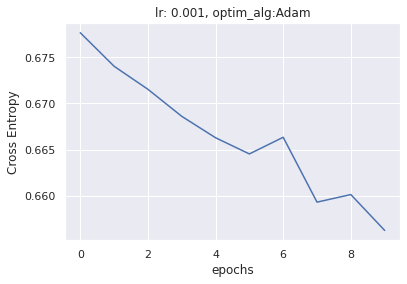

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_loss(loss_list):
  '''
  this function creates a plot. a simple curve showing the different values at each steps.
  Here we use it to plot the loss so we named it plot_loss, but the same function with different titles could be used to plot accuracies
  or other metrics for instance.
  
  Args:
    loss_list (list of floats): list of numerical values
  '''
  plt.plot(range(len(loss_list)), loss_list)
  plt.xlabel('epochs')
  # in our model we use Softmax then NLLLoss which means Cross Entropy loss
  plt.ylabel('Cross Entropy')
  # in our training loop we used an Adam optimizer so we indicate it there
  plt.title('lr: {}, optim_alg:{}'.format(args['lr'], 'Adam'))
  # let's directly show the plot when calling this function
  plt.show()

plot_loss(loss_list_val)

In [ ]:
#Evaluate

trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it = inference("test", test_loader, tweet_model)

test::   0%|          | 0/347 [00:00<?, ?it/s]


ValueError: ignored

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, plot_roc_curve
names = ['__dummy__', 'inform', 'question', 'directive', 'commissive']
print(classification_report(np.array(trues).flatten(), np.array(preds).flatten(), target_names=names, labels=[1, 2, 3, 4]))

              precision    recall  f1-score   support

      inform       0.38      0.48      0.42     10332
    question       0.00      0.00      0.00         0
   directive       0.00      0.00      0.00         0
  commissive       0.00      0.00      0.00         0

   micro avg       0.38      0.48      0.42     10332
   macro avg       0.09      0.12      0.11     10332
weighted avg       0.38      0.48      0.42     10332



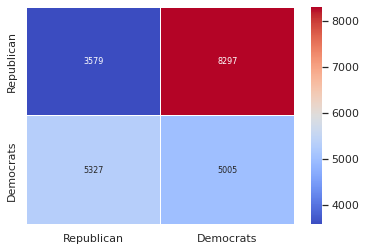

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, plot_roc_curve
import matplotlib.pyplot as plt
import seaborn as sn

cm = confusion_matrix(np.array(trues).flatten(), np.array(preds).flatten())
names = ['Republican', 'Democrats']
df_cm = pd.DataFrame(cm, index=names, columns=names)
# config plot sizes
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 8}, cmap='coolwarm', linewidth=0.5, fmt="")
plt.show()